# Diffusion Model From Scratch

In [1]:
from models import UNet

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

import torch.nn.functional as F

import torchvision.transforms as transforms
%matplotlib inline

## Viewing Dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


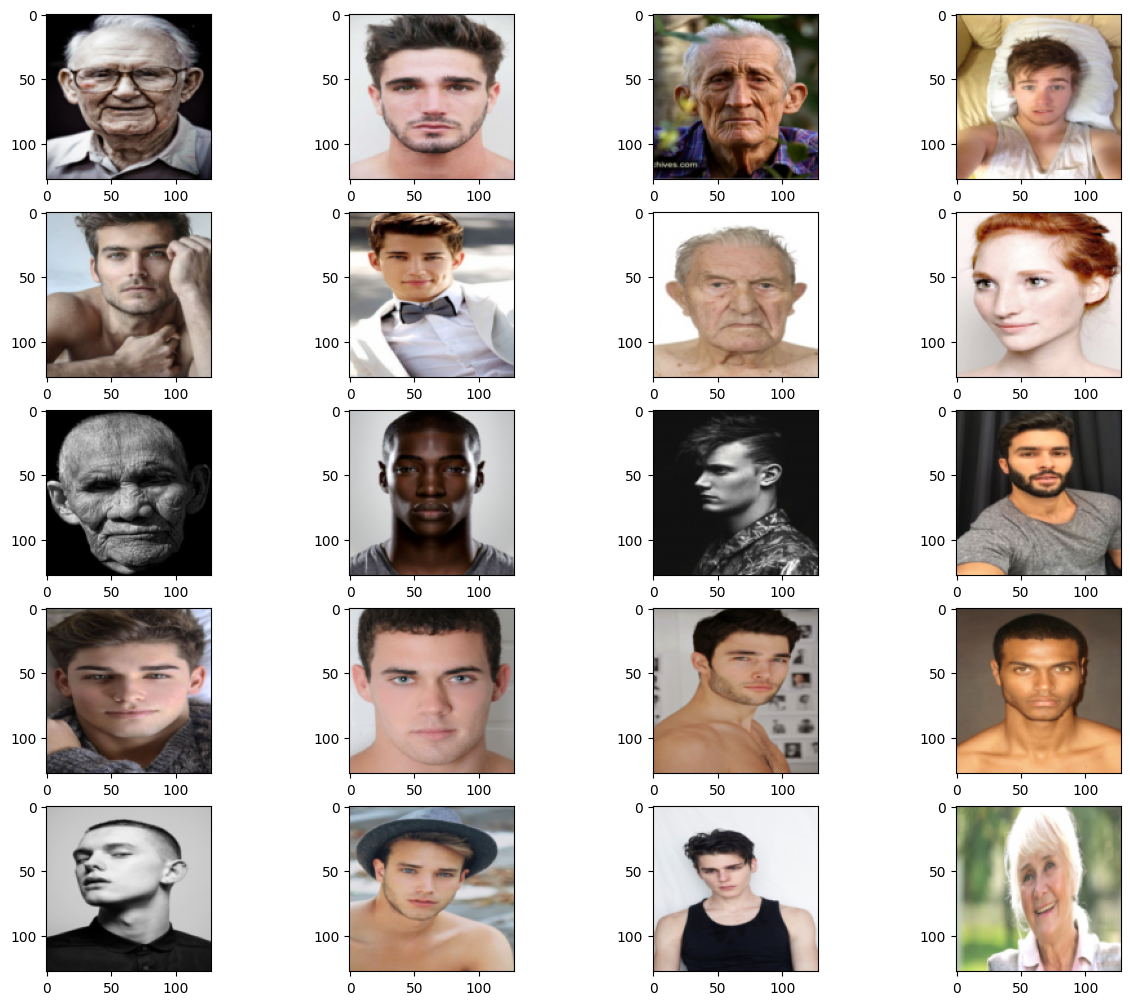

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, (img, *_) in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img.permute(1,2,0))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),

])
# data = torchvision.datasets.StanfordCars(root=".", download=True)
image_dir = r'..\Humans'
data = torchvision.datasets.ImageFolder(root=image_dir, transform=transform)
show_images(data)

## Forward Process

In [4]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 1000
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

## Data Loader And Viewing

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 32

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5,0.5,0.5))
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
    data_transform = transforms.Compose(data_transforms)

    # train = torchvision.datasets.StanfordCars(root=".", download=True,
    #                                      transform=data_transform)

    # test = torchvision.datasets.StanfordCars(root=".", download=True,
    #                                      transform=data_transform, split='test')
    image_dir = r'..\Humans'
    return torchvision.datasets.ImageFolder(image_dir, data_transform)
    # return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    # plt.figure(figsize=(5, 1))
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

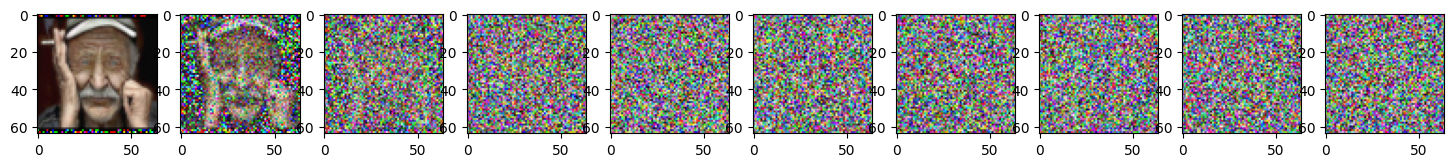

In [6]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

# plt.figure(figsize=(15,15))
# plt.axis('off')
num_images = 10
stepsize = int(T/num_images)
plt.figure(figsize=(20, 5))
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [7]:
import torchvision.models as models
from torchvision.models import VGG16_Weights

# vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
# vgg = vgg.eval()
# for param in vgg.parameters():
#     param.requires_grad = False

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
        vgg = vgg.eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.MSELoss()

    def forward(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = self.criterion(x_vgg, y_vgg)
        return loss

### Loss Function

In [8]:
criterion = PerceptualLoss().to(device)
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    # return criterion(noise, noise_pred)
    return F.l1_loss(noise, noise_pred)
    # return F.mse_loss(noise, noise_pred)

### Samplilng

In [9]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(20, 5))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        # print(img)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [10]:
# def denoise_image(model, noisy_image, t, betas, alphas_cumprod, sqrt_recip_alphas_cumprod, sqrt_recipm1_alphas_cumprod):
#     with torch.no_grad():
#         noisy_image = noisy_image.to(device)
#         timesteps = torch.arange(T-1, -1, -1, device=device).long()
#         for i in timesteps:
#             t = torch.full((noisy_image.size(0),), i, device=device, dtype=torch.long)
#             predicted_noise = model(noisy_image, t)
#             alpha = alphas_cumprod[i]
#             sqrt_recip_alpha = sqrt_recip_alphas_cumprod[i]
#             sqrt_recipm1_alpha = sqrt_recipm1_alphas_cumprod[i]
#             mean = sqrt_recip_alpha * (noisy_image - betas[i] * predicted_noise / sqrt_recipm1_alpha)
#             if i > 0:
#                 noise = torch.randn_like(noisy_image).to(device)
#                 variance = betas[i] * torch.sqrt(1 - alphas_cumprod[i - 1]) / (1 - alphas_cumprod[i])
#                 noisy_image = mean + variance * noise
#             else:
#                 noisy_image = mean
#         return noisy_image


In [11]:
# model

In [12]:
# sample_and_display(model, betas, alphas_cumprod, sqrt_recip_alphas_cumprod, sqrt_recipm1_alphas_cumprod)


### Training

In [13]:
import torch.optim as optim
from time import sleep
model = UNet(in_channels=3, time_embed_dim=128)
# model = torch.load('Testing_new_things.pth')
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 25 # Try more!

Epoch 0 Loss: 0.3871191143989563 :   9%|▉         | 83/902 [00:08<01:50,  7.42it/s] c:\Users\wolve\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 0 Loss: 0.254421591758728 : 100%|██████████| 902/902 [01:44<00:00,  8.60it/s]  


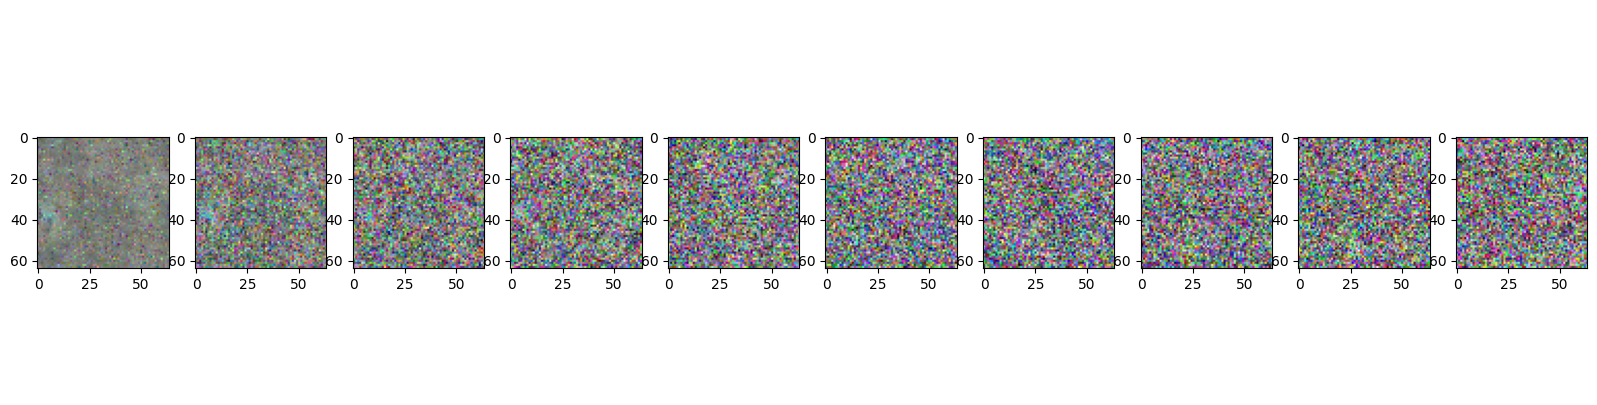

Epoch 1 Loss: 0.25941741466522217 : 100%|██████████| 902/902 [01:42<00:00,  8.77it/s]


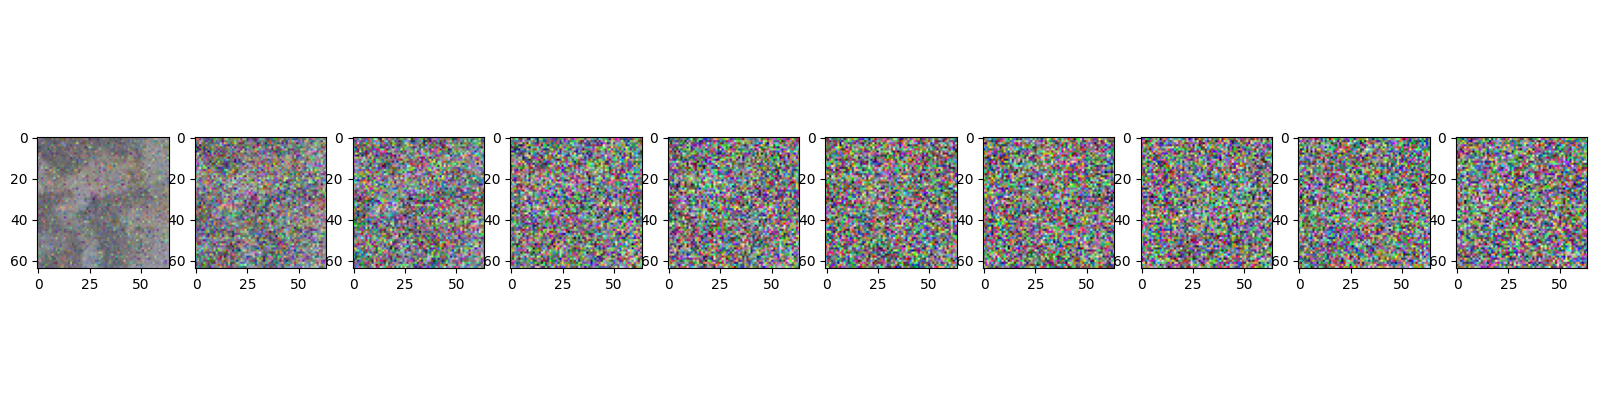

Epoch 2 Loss: 0.2194427251815796 : 100%|██████████| 902/902 [01:43<00:00,  8.71it/s] 


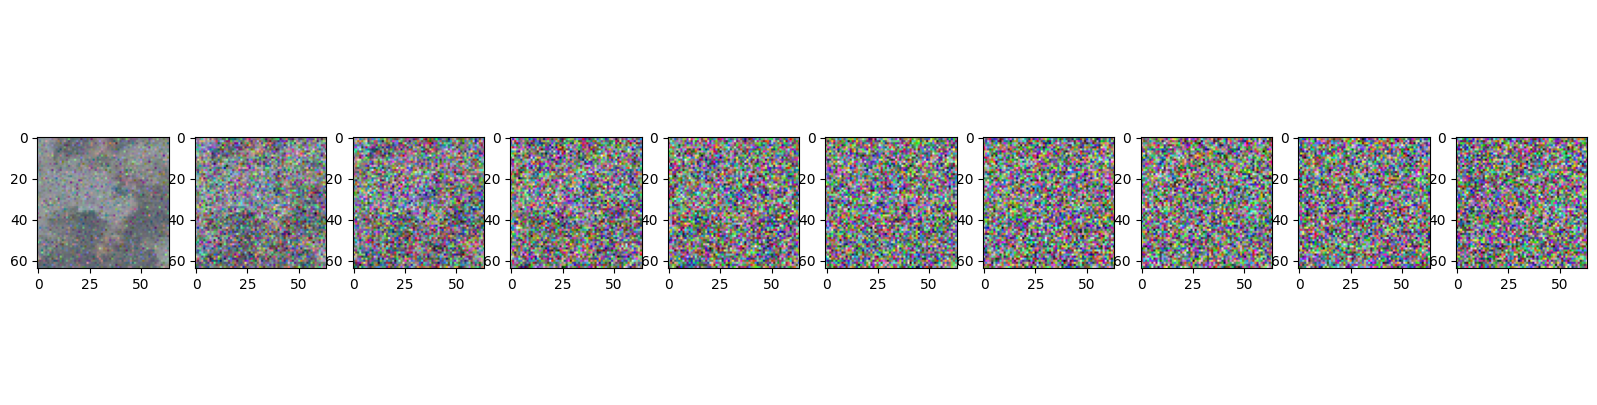

Epoch 3 Loss: 0.24013936519622803 :  10%|█         | 93/902 [00:08<01:16, 10.52it/s]


KeyboardInterrupt: 

In [14]:
from tqdm import tqdm
loss_graph = []

for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for batch in pbar:
      # print("HELLO")
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()
      pbar.set_description(f"Epoch {epoch} Loss: {loss.item()} ")
    sample_plot_image()
    

In [ ]:
torch.save(model, r'GELU_model.pth')

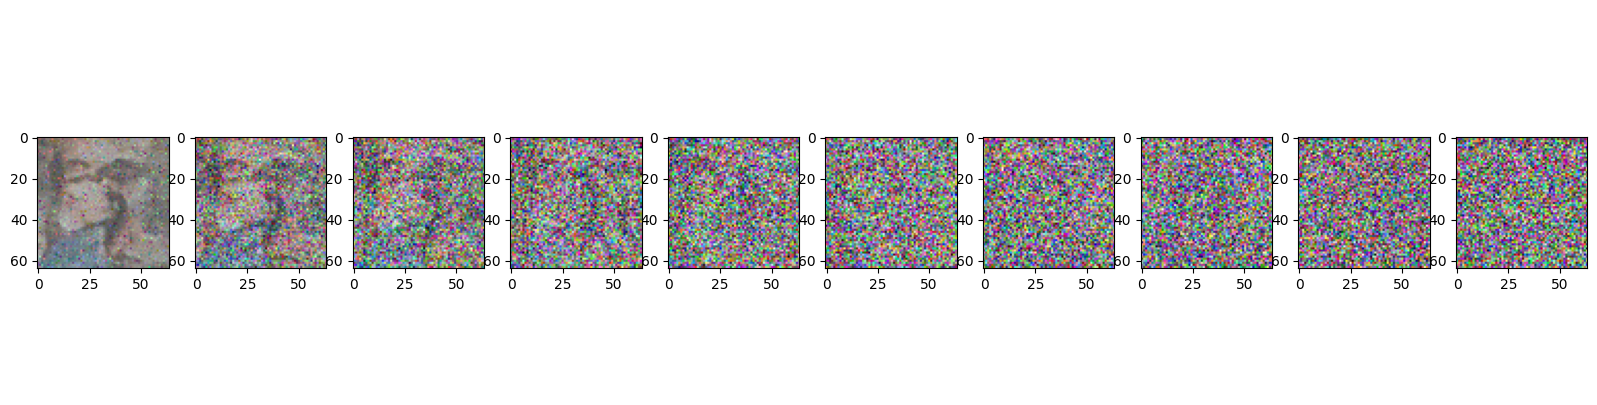

In [ ]:
sample_plot_image()

In [ ]:
torch.save(model, r'Testing_new_things.pth')

In [ ]:
# sample_plot_image()

In [ ]:
torch.load('GELU_model.pth')

UNet(
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): ConvBlock(
    (conv2d_0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv2d_1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv2d_2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (time_mlp): TimeEncodingBlock(
      (linear1): Linear(in_features=128, out_features=64, bias=True)
      (activation): ReLU(inplace=True)
      (linear2): Linear(i